In [1]:
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap, BeautifyIcon
import matplotlib.pyplot as plt
import geopy
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from operator import itemgetter
%matplotlib inline

### Data cleaning

In [2]:
data1 = pd.read_csv("accidents_2005_to_2007.csv", low_memory=False)
data2 = pd.read_csv("accidents_2009_to_2011.csv", low_memory=False)
data3 = pd.read_csv("accidents_2012_to_2014.csv", low_memory=False)

- 2008 missing

In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570011 entries, 0 to 570010
Data columns (total 33 columns):
Accident_Index                                 570011 non-null object
Location_Easting_OSGR                          569910 non-null float64
Location_Northing_OSGR                         569910 non-null float64
Longitude                                      569910 non-null float64
Latitude                                       569910 non-null float64
Police_Force                                   570011 non-null int64
Accident_Severity                              570011 non-null int64
Number_of_Vehicles                             570011 non-null int64
Number_of_Casualties                           570011 non-null int64
Date                                           570011 non-null object
Day_of_Week                                    570011 non-null int64
Time                                           569944 non-null object
Local_Authority_(District)                     570

In [4]:
data1.shape, data2.shape, data3.shape

((570011, 33), (469442, 33), (464697, 33))

In [5]:
df = pd.concat([data1, data2, data3])

df.shape

(1504150, 33)

In [6]:
df.isna().sum()

Accident_Index                                       0
Location_Easting_OSGR                              101
Location_Northing_OSGR                             101
Longitude                                          101
Latitude                                           101
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Date                                                 0
Day_of_Week                                          0
Time                                               117
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                                            0
Speed_limit                                          0
Junction_D

In [7]:
df.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Speed_limit,Junction_Detail,2nd_Road_Class,2nd_Road_Number,Urban_or_Rural_Area,Year
count,1.504049e+06,1.504049e+06,1.504049e+06,1.504049e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,0.0,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06
mean,4.396214e+05,3.001584e+05,-1.436625e+00,5.258940e+01,3.020536e+01,2.838190e+00,1.831606e+00,1.350960e+00,4.118607e+00,3.476149e+02,4.087999e+00,1.009919e+03,3.900540e+01,NaN,2.675084e+00,3.815684e+02,1.353871e+00,2.009370e+03
std,9.511616e+04,1.610084e+05,1.398078e+00,1.449889e+00,2.551603e+01,4.018423e-01,7.147586e-01,8.253345e-01,1.924405e+00,2.594292e+02,1.428936e+00,1.823518e+03,1.413993e+01,NaN,3.205539e+00,1.302555e+03,4.783534e-01,3.013497e+00
min,6.495000e+04,1.029000e+04,-7.516225e+00,4.991294e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+01,NaN,-1.000000e+00,-1.000000e+00,1.000000e+00,2.005000e+03
25%,3.750600e+05,1.782600e+05,-2.373902e+00,5.149016e+01,6.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.100000e+02,3.000000e+00,0.000000e+00,3.000000e+01,NaN,-1.000000e+00,0.000000e+00,1.000000e+00,2.006000e+03
50%,4.399600e+05,2.688300e+05,-1.403714e+00,5.230913e+01,3.000000e+01,3.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,3.220000e+02,4.000000e+00,1.290000e+02,3.000000e+01,NaN,3.000000e+00,0.000000e+00,1.000000e+00,2.010000e+03
75%,5.230600e+05,3.981510e+05,-2.215100e-01,5.347858e+01,4.500000e+01,3.000000e+00,2.000000e+00,1.000000e+00,6.000000e+00,5.180000e+02,6.000000e+00,7.250000e+02,5.000000e+01,NaN,6.000000e+00,0.000000e+00,2.000000e+00,2.012000e+03
max,6.553700e+05,1.208800e+06,1.759398e+00,6.075754e+01,9.800000e+01,3.000000e+00,6.700000e+01,9.300000e+01,7.000000e+00,9.410000e+02,6.000000e+00,9.999000e+03,7.000000e+01,NaN,6.000000e+00,9.999000e+03,3.000000e+00,2.014000e+03


In [8]:
# creating one datetime index to replace the four date columns

df["Date"] =  df["Date"] + " " + df["Time"]
df["Date"] = pd.to_datetime(df.Date, format="%d/%m/%Y %H:%M")

df = df.set_index("Date")

In [9]:
# dropping NaNs

df.dropna(subset=["Latitude", "Longitude", "Time"], inplace=True)

df.drop(["Time", "Year", "Day_of_Week", "Accident_Index", "Location_Easting_OSGR", "Location_Northing_OSGR", "Junction_Detail", "Junction_Control"], axis=1, inplace=True) #  "2nd_Road_Class", "2nd_Road_Number"

df.shape

(1503932, 24)

In [10]:
df.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04 17:42:00,-0.191170,51.489096,1,2,1,1,12,E09000020,3,3218,...,None within 50 metres,Zebra crossing,Daylight: Street light present,Raining without high winds,Wet/Damp,None,None,1,Yes,E01002849
2005-01-05 17:36:00,-0.211708,51.520075,1,3,1,1,12,E09000020,4,450,...,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002909
2005-01-06 00:15:00,-0.206458,51.525301,1,3,2,1,12,E09000020,5,0,...,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002857
2005-01-07 10:35:00,-0.173862,51.482442,1,3,1,1,12,E09000020,3,3220,...,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,E01002840
2005-01-10 21:13:00,-0.156618,51.495752,1,3,1,1,12,E09000020,6,0,...,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lighting unknown,Fine without high winds,Wet/Damp,None,None,1,Yes,E01002863


# Data Exploration:


### Remarks:
- Problem: only data of accidents, no data of non-accidents
- hence focus on accident severity



## When do accidents happen? 
- Q4) Is there any seasonality effect in the dataset?
- Q5) What is the most dangerous time in the day?

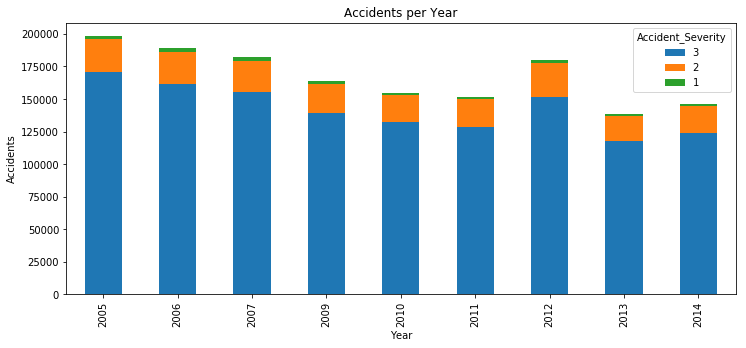

In [11]:
df2 = df.groupby([df.index.year, "Accident_Severity"]).size().unstack("Accident_Severity")

ax = df2[[3,2,1]].plot(kind="bar", stacked="True", figsize=(12,5))
ax.set(title="Accidents per Year", xlabel="Year", ylabel="Accidents")
plt.show()

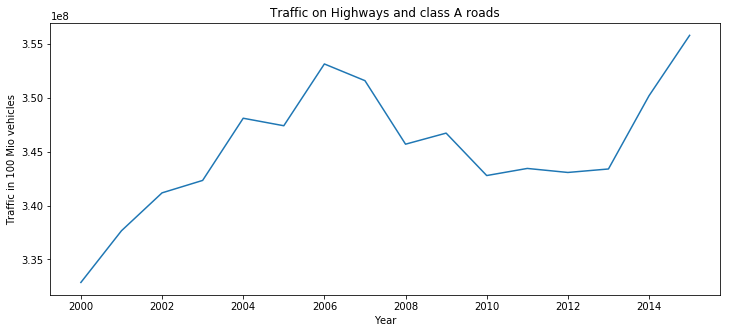

In [13]:
traffic = pd.read_csv("ukTrafficAADF.csv")
traffic = traffic[traffic["AADFYear"] != 2016]
ax = traffic.groupby("AADFYear")["AllMotorVehicles"].sum().plot(figsize=(12,5))
ax.set(title="Traffic on Highways and class A roads", xlabel="Year", ylabel="Traffic in 100 Mio vehicles")
plt.show()

### Observations:
- downwards trend of accidents over the years
- 2012 outlier, cannot be explained by more traffic in that year (at least not on highways or class A roads)

In [33]:
# Identifying duplicates

group = df.groupby(df.index.year).apply(pd.DataFrame.duplicated)
group.groupby(level=0).sum()

Date
2005      428.0
2006      495.0
2007      395.0
2009      420.0
2010      427.0
2011      463.0
2012    34485.0
2013      317.0
2014      381.0
dtype: float64

In [34]:
df = df.drop_duplicates()

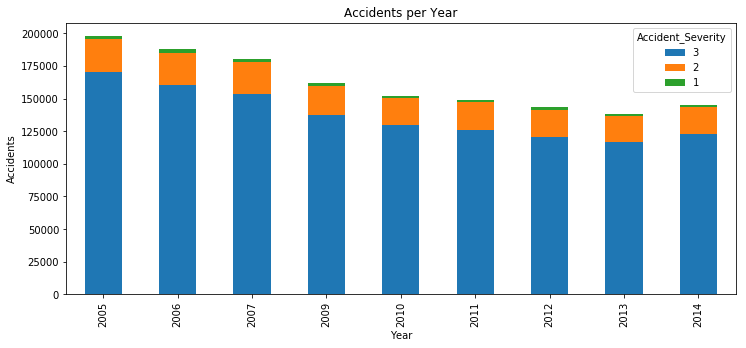

In [35]:
df2 = df.groupby([df.index.year, "Accident_Severity"]).size().unstack("Accident_Severity")

ax = df2[[3,2,1]].plot(kind="bar", stacked="True", figsize=(12,5))
ax.set(title="Accidents per Year", xlabel="Year", ylabel="Accidents")
plt.show()

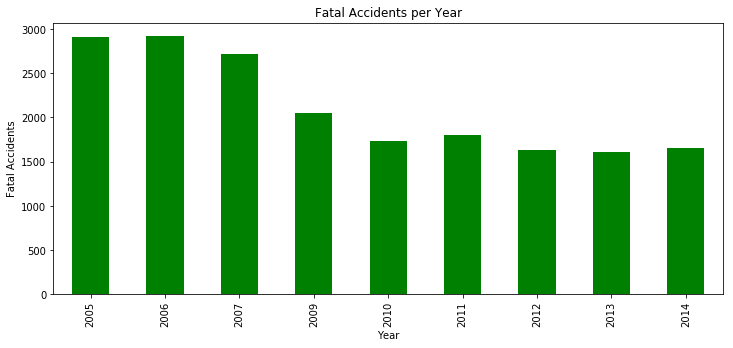

In [37]:
df2 = df[df["Accident_Severity"] == 1]
df2 = df2.groupby(df2.index.year).size()

ax = df2.plot(kind="bar", stacked="True", figsize=(12,5), color="green")
ax.set(title="Fatal Accidents per Year", xlabel="Year", ylabel="Fatal Accidents")
plt.show()

### Observations:
- nice downwards trend of accidents over the years
- cause is not clear, could be:
    - less traffic in cities
    - better traffic policies that mitigate accidents
    - better cars

### Q4) Seasonality Effect

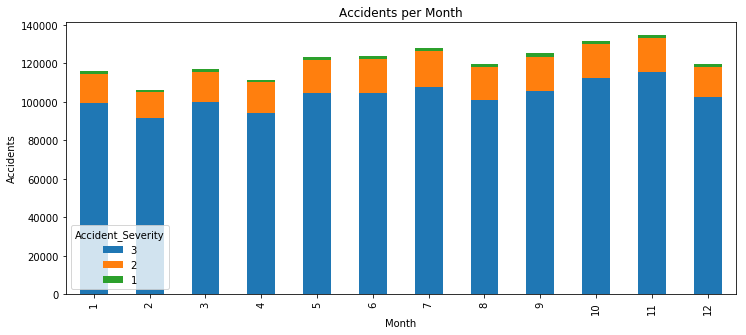

In [38]:
df2 = df.groupby([df.index.month, df.Accident_Severity]).size().unstack("Accident_Severity")

ax = df2[[3,2,1]].plot(kind="bar", stacked="True", figsize=(12,5))
ax.set(title="Accidents per Month", xlabel="Month", ylabel="Accidents")
plt.show()

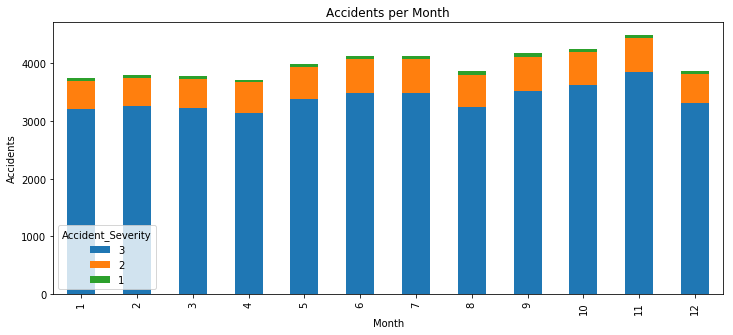

In [39]:
df2 = df2.divide([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], axis=0)

ax = df2[[3,2,1]].plot(kind="bar", stacked="True", figsize=(12,5))
ax.set(title="Accidents per Month", xlabel="Month", ylabel="Accidents")
plt.show()

### Obersations:
- no big seasonality effect observable, maybe somewhat less accidents at the beginning of the year than at the end of the year
- does not necessarily mean that there is no seasonality effect (more/less traffic during winter/summer)
- plausible that there is not much seasonality since the UK does not suffer that much from seasons (for example snow)

### Accidents per day of week / time of day:

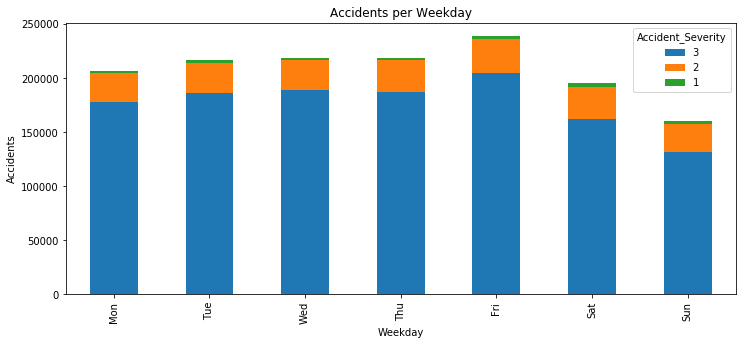

In [20]:
df2 = df.groupby([df.index.weekday, df.Accident_Severity]).size().unstack("Accident_Severity")

ax = df2[[3,2,1]].plot(kind="bar", stacked="True", figsize=(12,5))
ax.set_xticklabels(["Mon","Tue" , "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set(title="Accidents per Weekday", xlabel="Weekday", ylabel="Accidents")
plt.show()

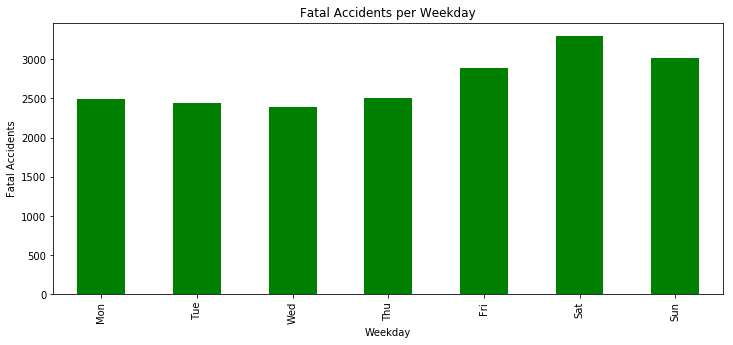

In [21]:
ax = df2[1].plot(kind="bar", figsize=(12,5), color = "green")
ax.set_xticklabels(["Mon","Tue" , "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set(title="Fatal Accidents per Weekday", xlabel="Weekday", ylabel="Fatal Accidents")
plt.show()

### Q5) Most dangerous time of day

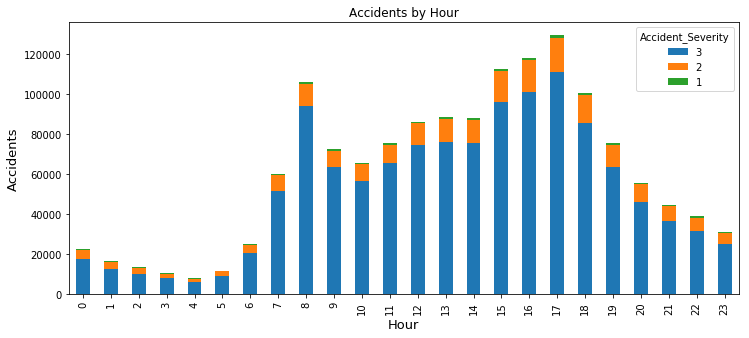

In [50]:
df2 = df.groupby([df.index.hour, df.Accident_Severity]).size().unstack("Accident_Severity")
ax = df2[[3, 2, 1]].plot(kind="bar", stacked=True, figsize=(12,5))
ax.set_xlabel("Hour", fontsize = 13) 
ax.set_ylabel("Accidents", fontsize = 13)
ax.set_title("Accidents by Hour")
plt.show()

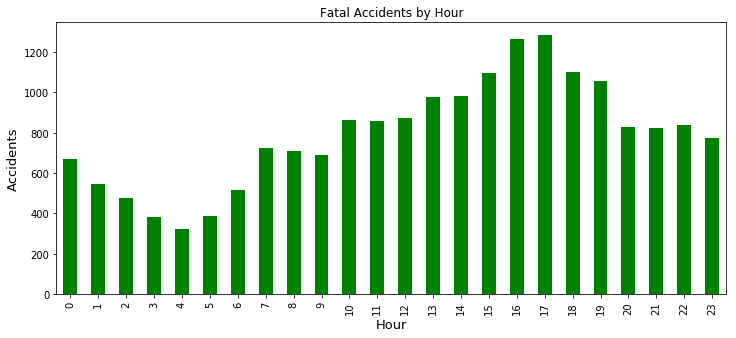

In [51]:
ax = df2[1].plot(kind="bar", figsize=(12,5), color="green")
ax.set_xlabel("Hour", fontsize = 13) 
ax.set_ylabel("Accidents", fontsize = 13)
ax.set_title("Fatal Accidents by Hour")
plt.show()

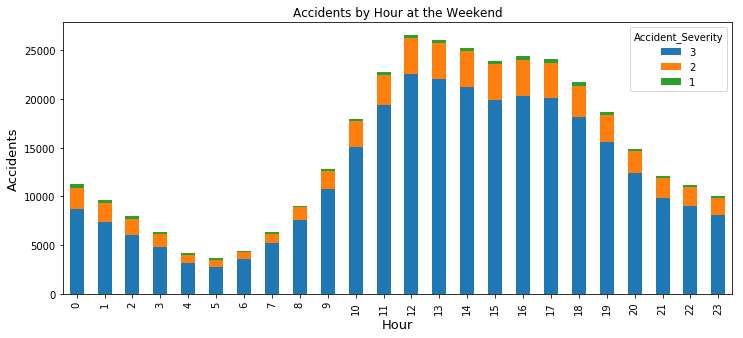

In [52]:
df2 = df[df.index.weekday > 4]
df2 = df2.groupby([df2.index.hour, df2.Accident_Severity]).size().unstack("Accident_Severity")
ax = df2[[3, 2, 1]].plot(kind="bar", stacked=True, figsize=(12,5))
ax.set_xlabel("Hour", fontsize = 13) 
ax.set_ylabel("Accidents", fontsize = 13)
ax.set_title("Accidents by Hour at the Weekend")
plt.show()

In [53]:
night = df[((df.index.hour >= 20) | (df.index.hour <= 5))]
day = df[((df.index.hour > 5) & (df.index.hour < 20))]

In [54]:
day.groupby("Accident_Severity").size() * 100 / day.shape[0]

Accident_Severity
1     1.080473
2    12.891605
3    86.027921
dtype: float64

In [55]:
night.groupby("Accident_Severity").size() * 100 / night.shape[0]

Accident_Severity
1     2.390467
2    17.207245
3    80.402288
dtype: float64

In [56]:
stats.ttest_ind(day["Accident_Severity"], night["Accident_Severity"])

Ttest_indResult(statistic=78.84682572516908, pvalue=0.0)

### Observations:
- Weekday vs Weekend:
    - most accidents happen during the week (probably because of more traffic)
    - severe/fatal accidents are more likely to happen at the weekend than during the week (probably because of drunk driving)
- Time of Day:
    - most accidents happen during the rush hours when people go to or come from work due to more traffic
    - severe/fatal accidents are more likely to happen during the night than during the day (probably because of tiredness and drunk driving)

## Where do accidents happen?
- general observations
- Q2) Identify the areas with the most accidents
- Q3) What is the most dangerous road?

In [61]:
heat_data_slight = df[df["Accident_Severity"] == 3][["Latitude", "Longitude"]].sample(10000)
heat_data_fatal = df[df["Accident_Severity"] == 1][["Latitude", "Longitude"]].sample(10000)

In [62]:
heat_data_slight = [[row["Latitude"], row["Longitude"]] for index, row in heat_data_slight.iterrows()]
heat_data_fatal = [[row["Latitude"], row["Longitude"]] for index, row in heat_data_fatal.iterrows()]

In [63]:
map_uk = folium.Map(location=[53, -0.5], zoom_start = 7) 

HeatMap(heat_data_slight, radius=5, blur=5).add_to(map_uk)

map_uk

In [64]:
map_uk = folium.Map(location=[53, -0.5], zoom_start = 7) 

HeatMap(heat_data_fatal, radius=5, blur=5).add_to(map_uk)

map_uk

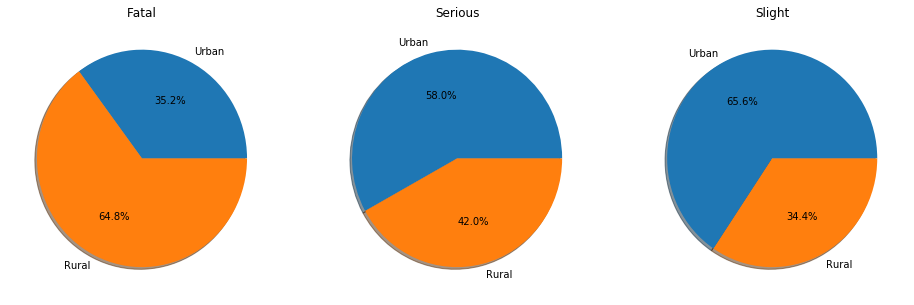

In [65]:
urban_rural = df[df["Urban_or_Rural_Area"] <= 2].groupby(["Accident_Severity", "Urban_or_Rural_Area"]).size()


fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (sev, (urban, rural)) in enumerate(urban_rural.unstack(1).iterrows()):
    axes[idx].pie([urban, rural], labels = ["Urban", "Rural"], autopct='%1.1f%%', shadow=True)
    axes[idx].set_title(["Fatal", "Serious", "Slight"][idx])

plt.show()

In [66]:
urban_rural = df[df["Urban_or_Rural_Area"] <= 2].groupby(["Urban_or_Rural_Area","Accident_Severity"]).size()
urban_rural.groupby(level=0).apply(lambda x: np.round(100 * x / np.sum(x), 2))

Urban_or_Rural_Area  Accident_Severity
1                    1                     0.72
                     2                    12.34
                     3                    86.94
2                    1                     2.36
                     2                    15.97
                     3                    81.67
dtype: float64

In [67]:
stats.ttest_ind(df[df["Urban_or_Rural_Area"] == 1]["Accident_Severity"], df[df["Urban_or_Rural_Area"] == 2]["Accident_Severity"])

Ttest_indResult(statistic=99.73300790624316, pvalue=0.0)

#### Observation:
- urban areas seem to have a higher proportion of slight accidents
- rural areas seem to see a higher accident severity than urban areas
- effect might be explained by higher speed limits in rural areas and people paying less attention in remote rural areas

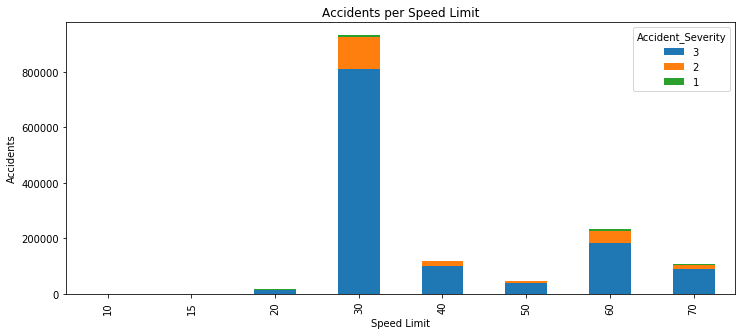

In [68]:
df2 = df.groupby([df.Speed_limit, df.Accident_Severity]).size().unstack("Accident_Severity")

ax = df2[[3,2,1]].plot(kind="bar", stacked="True", figsize=(12,5))
ax.set(title="Accidents per Speed Limit", xlabel="Speed Limit", ylabel="Accidents")
plt.show()

In [69]:
speed = df[df["Speed_limit"] >= 30].groupby(["Speed_limit", "Accident_Severity"]).size()
speed.groupby(level=0).apply(lambda x: np.round(100 * x / x.sum(), 2))

Speed_limit  Accident_Severity
30           1                     0.67
             2                    12.50
             3                    86.82
40           1                     1.47
             2                    13.60
             3                    84.93
50           1                     2.16
             2                    14.79
             3                    83.06
60           1                     3.15
             2                    18.66
             3                    78.19
70           1                     2.34
             2                    12.00
             3                    85.66
dtype: float64

In [70]:
np.corrcoef(df["Speed_limit"], df["Urban_or_Rural_Area"])

array([[1.        , 0.68385543],
       [0.68385543, 1.        ]])

### Q2) Area with most accidents:
####  By LSOA (Lower Super Output Area - similar to ZIP code)

In [71]:
acc_top10 = df.groupby("LSOA_of_Accident_Location").size().sort_values(ascending=False).head(10)

In [72]:
acc_top10

LSOA_of_Accident_Location
E01000004    1985
E01011365    1265
E01004736    1247
E01008440     914
E01002444     797
E01005131     789
E01004764     764
E01018648     753
E01023722     697
E01004689     618
dtype: int64

In [73]:
map_uk = folium.Map(location=[53.5, -0.1], zoom_start = 6) 

for rank, (idx, val) in enumerate(acc_top10.iteritems(), 1):
    lsoa = df[df["LSOA_of_Accident_Location"] == idx]
    
    number_icon = BeautifyIcon(text_color='#000', border_color='transparent', icon='arrow-down', icon_shape='marker',
                                background_color='green', number=rank, inner_icon_style='font-size:12px;padding-top:-5px;')
    
    folium.Marker(
        location=lsoa[["Latitude", "Longitude"]].mean().values,
        popup=f"Nr. {rank}: {val} accidents",
        icon=number_icon
        ).add_to(map_uk)
    
    heat_data = [[row["Latitude"], row["Longitude"]] for index, row in lsoa.iterrows()]
    HeatMap(heat_data, radius=10, blur=10).add_to(map_uk)

map_uk

In [74]:
fatal_top10 = df[df["Accident_Severity"] == 1].groupby("LSOA_of_Accident_Location").size().sort_values(ascending=False).head(10)

In [75]:
fatal_top10

LSOA_of_Accident_Location
E01025808    15
E01031477    15
E01018648    14
E01001412    13
E01028000    13
E01018597    12
E01032010    12
E01026993    12
E01019736    12
E01032026    12
dtype: int64

In [76]:
map_uk = folium.Map(location=[53.5, -0.1], zoom_start = 6) 

for rank, (idx, val) in enumerate(fatal_top10.iteritems(), 1):
    lsoa = df[(df["LSOA_of_Accident_Location"] == idx) & (df["Accident_Severity"] == 1)]
    
    number_icon = BeautifyIcon(text_color='#000', border_color='transparent', icon='arrow-down', icon_shape='marker',
                                background_color='green', number=rank, inner_icon_style='font-size:12px;padding-top:-5px;')
    
    folium.Marker(
        location=lsoa[["Latitude", "Longitude"]].mean().values,
        popup=f"Nr. {rank}: {val} accidents",
        icon=number_icon
        ).add_to(map_uk)
    
    heat_data = [[row["Latitude"], row["Longitude"]] for index, row in lsoa.iterrows()]
    HeatMap(heat_data, radius=10, blur=10).add_to(map_uk)

map_uk

#### Observations:
- areas with the most accidents are in the city centres (although Birmingham seems to have fewer accidents than expected, maybe due to LSOA distribution)
- LSOA might not be a fair way to group accidents by in order to see in which area the most accidents happen:
    - roughly 1500 people live in each LSOA
    - this does not mean that in each LSOA there is roughly the same amount of traffic
- there does not seem to be an area where especially many fatal accidents happen (no outlier)

### Alternative: Group by Police Department

In [24]:
police = df.groupby("Police_Force").size().sort_values(ascending=False).head()

In [26]:
map_uk = folium.Map(location=[51.5, -0.1], zoom_start = 6) 

for rank, (pol, val) in enumerate(police.iteritems(), 1):
    area = df[df["Police_Force"] == pol]
    
    number_icon = BeautifyIcon(text_color='#000', border_color='transparent', icon='arrow-down', icon_shape='marker',
                                background_color='green', number=rank, inner_icon_style='font-size:12px;padding-top:-5px;')
    
    folium.Marker(
        location=area[["Latitude", "Longitude"]].mean().values,
        popup=f"Nr. {rank}: {val} accidents",
        icon=number_icon
        ).add_to(map_uk)
    
    heat_data = [[row["Latitude"], row["Longitude"]] for index, row in area.sample(frac=0.1).iterrows()]
    HeatMap(heat_data, radius=10, blur=10).add_to(map_uk)

map_uk

### Q3) Most dangerous street

#### Approach 1: Group by Street Number

In [77]:
most_dangerous = df.groupby("1st_Road_Number").size().sort_values(ascending=False).iloc[1:4]

In [78]:
most_dangerous

1st_Road_Number
1    18400
6    15800
4    13757
dtype: int64

In [79]:
map_uk = folium.Map(location=[51.5, -0.1], zoom_start = 6) 

for rank, (str_nr, val) in enumerate(most_dangerous.iteritems(), 1):
    area = df[df["1st_Road_Number"] == str_nr]
    
    number_icon = BeautifyIcon(text_color='#000', border_color='transparent', icon='arrow-down', icon_shape='marker',
                                background_color='green', number=rank, inner_icon_style='font-size:12px;padding-top:-5px;')
    
    folium.Marker(
        location=area[["Latitude", "Longitude"]].iloc[5000].values,
        popup=f"Nr. {rank}: {val} accidents",
        icon=number_icon
        ).add_to(map_uk)
    
    heat_data = [[row["Latitude"], row["Longitude"]] for index, row in area.sample(int(area.shape[0]/3)).iterrows()]
    HeatMap(heat_data, radius=10, blur=10).add_to(map_uk)

map_uk

### Observations:
- huge Roads/Highways
- a lot of missing values (~350k) (smaller roads)
- maybe some wrong street assignments (spots way off the roads)

### Approach 2: Look up street names

In [80]:
london = df[(df["Latitude"] > 51.48) & (df["Latitude"] < 51.55) & (df["Longitude"] > -0.17) & (df["Longitude"] < 0)]

In [81]:
geolocator = geopy.geocoders.Nominatim(user_agent="specify_your_app_name_here")

In [82]:
location = geolocator.reverse("51.486552, -0.160590")

In [83]:
location.address

'28, Tite Street, Chelsea, Royal Borough of Kensington and Chelsea, London, Greater London, England, SW3, UK'

In [ ]:
addresses = []
count = 1
for idx, (lat, lon) in london[["Latitude", "Longitude"]].iterrows():
    try:
        addresses.append(geolocator.reverse(f"{lat}, {lon}").raw["address"].get("road", np.NaN))
    except:
        print(f"Failed at index {idx}")
    count += 1
    if count % 100 == 0:
        print(count)

100
200
Failed at index 2005-07-15 09:20:00
300
Failed at index 2005-08-04 17:00:00
Failed at index 2005-08-17 11:34:00
Failed at index 2005-08-25 00:41:00
Failed at index 2005-08-26 20:56:00
Failed at index 2005-08-16 08:00:00


#### Problem:
    - very slow (~6 lookups/sec) -> would take ~3 days to lookup all 1.5Mio streets
    - lookup limit

### Approach 3: round the coordinates to a certain number of decimals then group by coordinates

In [90]:
df["lon_rd"] = np.round(df.Longitude, decimals=2)
df["lat_rd"] = np.round(df.Latitude, decimals=3)

In [91]:
most_dangerous = df.groupby(["lon_rd", "lat_rd"]).size().sort_values(ascending=False).head(10)

In [92]:
map_uk = folium.Map(location=[51.5, -0.1], zoom_start = 6) 

for rank, ((lon, lat), val) in enumerate(most_dangerous.iteritems(), 1):
    area = df[(df["lat_rd"] == lat) & (df["lon_rd"] == lon)]
    
    number_icon = BeautifyIcon(text_color='#000', border_color='transparent', icon='arrow-down', icon_shape='marker',
                                background_color='green', number=rank, inner_icon_style='font-size:12px;padding-top:-5px;')
    
    folium.Marker(
        location=area[["Latitude", "Longitude"]].mean().values,
        popup=f"Nr. {rank}: {val} accidents",
        icon=number_icon
        ).add_to(map_uk)
    
    heat_data = [[row["Latitude"], row["Longitude"]] for index, row in area.iterrows()]
    HeatMap(heat_data, radius=10, blur=10).add_to(map_uk)

map_uk

### Observations:
- Oxford street seems to be the most dangerous road

## Accident Causes & Accident Prediction
- Q6) What are the most important causes for accidents
- Q7) Create a predictive model to evaluate the probability of car accidents

#### Problem:
- can't identify accident causes since there is no data from non-accidents
- can only identify causes for accident severity, such as:
    - time of day
    - speed limit
    - urban/rural area

In [93]:
weather = df.groupby(["Weather_Conditions", "Accident_Severity"]).size()
weather2 = pd.concat([weather.groupby(level=0).apply(lambda x: np.round(100 * x / x.sum(), 2)), weather], axis=1)
weather2.columns = [["relative", "absolute"]]
weather2

relative absolute
Weather_Conditions         Accident_Severity                  
Fine with high winds       1                     1.84      333
                           2                    14.64     2650
                           3                    83.51    15112
Fine without high winds    1                     1.36    15808
                           2                    14.09   163850
                           3                    84.55   983083
Fog or mist                1                     2.14      172
                           2                    14.09     1134
                           3                    83.77     6742
Other                      1                     0.88      290
                           2                    10.90     3585
                           3                    88.22    29023
Raining with high winds    1                     1.35      275
                           2                    13.25     2697
                           3                    85.40    17380
Raining without high winds 1                     1.05     1816
                           2                    12.02    20730
                           3                    86.93   149979
Snowing with high winds    1                     0.67       13
                           2                    11.50      222
                           3                    87.83     1696
Snowing without high winds 1                     0.80       89
                           2                     9.55     1064
                           3                    89.65     9987
Unknown                    1                     0.86      239
                           2                     9.43     2613
                           3                    89.71    24852

### Random Forest

In [111]:
data = df[(df.Speed_limit >= 30) & (df.Urban_or_Rural_Area <= 2)].copy()

# creating time variable: Night, Peak, Off-Peak

data["Time"] = np.where((data.index.hour <= 5) | (data.index.hour >= 20), "Night", 
                     np.where((data.index.hour >= 10) & (data.index.hour <= 14), "Off-Peak", "Peak"))

In [112]:
y = data["Accident_Severity"].reset_index(drop=True)
X = data[["1st_Road_Class", "Speed_limit", "Weather_Conditions", "Urban_or_Rural_Area", "Time"]].reset_index(drop=True)
X_dum = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.25, random_state=42)

In [104]:
clf = RandomForestClassifier(n_estimators=100,max_depth=4, random_state=28)

In [105]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=28, verbose=0, warm_start=False)

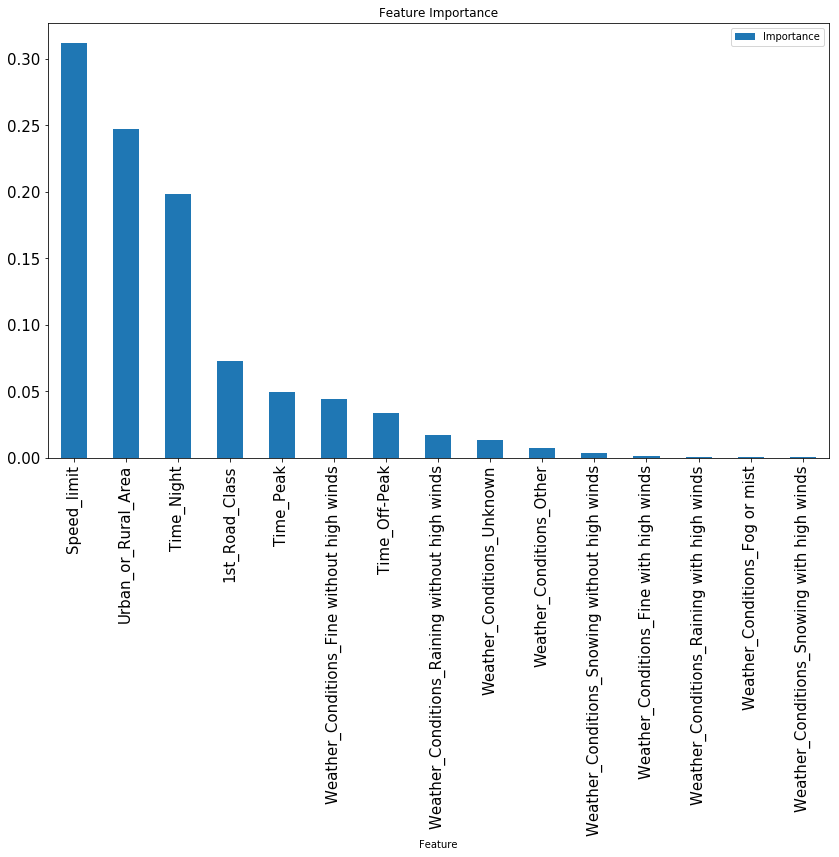

In [106]:
importance = sorted(zip(X_train.columns, clf.feature_importances_), key=itemgetter(1), reverse=True)
fe_imp = pd.DataFrame(importance, columns=["Feature", "Importance"]).set_index("Feature")
fe_imp.plot(figsize=(14, 8),kind="bar", title="Feature Importance", fontsize=15)
plt.show()

#### Observations:
- as mentioned before speed limit, urban/rural area and time of day are the most important factors of this dataset
- other possible causes (which cannot be examined with this dataset) might for example be the driver's age or the type of car etc

In [107]:
rdf_preds = clf.predict_proba(X_test)

In [108]:
preds = pd.DataFrame(rdf_preds, columns=["pred_fatal", "pred_serious", "pred_slight"])
preds = pd.concat([preds, pd.get_dummies(y_test).reset_index(drop=True)], axis=1)
preds.rename(index=str, columns={1: "fatal", 2: "serious", 3: "slight"}, inplace=True)

preds.head()

,pred_fatal,pred_serious,pred_slight,fatal,serious,slight
0,0.007422,0.121186,0.871392,0,0,1
1,0.007104,0.125056,0.867840,0,0,1
2,0.006829,0.125576,0.867595,0,0,1
3,0.007422,0.121186,0.871392,0,0,1
4,0.007747,0.125948,0.866306,0,0,1


In [109]:
def rps(prob_fatal, prob_serious, fatal, serious):
    """
    Calculates the rank probability score
    prob_ -> predicted probability
    fatal, serious -> 0 or 1 for actual result
    The lower RPS the better
    """
    step1 = prob_fatal - fatal
    step2 = prob_serious - serious
    summe = step1 + step2
    rps = (step1 ** 2 + summe ** 2) / 2
    return rps

In [113]:
y_train.value_counts() / y_train.shape[0]

3    0.850627
2    0.136282
1    0.013091
Name: Accident_Severity, dtype: float64

In [114]:
preds["rps_pred"] = rps(preds["pred_fatal"], preds["pred_serious"], preds["fatal"], preds["serious"]) #random forest prediction
preds["rps_dummy"] = rps(0, 0, preds["fatal"], preds["serious"]) #dummy prediction -> always slight accident
preds["rps_mean"] = rps(0.013091, 0.136282, preds["fatal"], preds["serious"]) #prediction of sample mean

In [115]:
preds.tail()

,pred_fatal,pred_serious,pred_slight,fatal,serious,slight,rps_pred,rps_dummy,rps_mean
359773,0.021185,0.150051,0.828765,0,0,1,0.014885,0.0,0.011242
359774,0.007732,0.119905,0.872363,0,0,1,0.008175,0.0,0.011242
359775,0.005783,0.114201,0.880016,0,0,1,0.007215,0.0,0.011242
359776,0.007104,0.125056,0.867840,0,0,1,0.008758,0.0,0.011242
359777,0.006829,0.125576,0.867595,0,0,1,0.008789,0.0,0.011242


#### Rank Probability Score

The RPS considers that for example a serious accident is closer to a fatal accident than an slight accident is to a fatal accident.
Formally:
$$RPS = \frac{1}{r-1}\sum_{i=1}^r\left(\sum_{j=1}^i p_j - \sum_{j=1}^i e_j\right)^2$$
with $r$ being the number of potential outcomes, $p_j$ the prediction and $e_j$ the actual outcome at position $j$.

In [116]:
preds["rps_pred"].mean()

0.06946107879358296

In [117]:
preds["rps_dummy"].mean()

0.08163089460723001

In [118]:
preds["rps_mean"].mean()

0.07030820637909944

In [119]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

C:\Users\Konny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [120]:
def loss_rps(y_true, y_pred):
    prob_h = y_pred[:, 0]
    prob_d = y_pred[:, 1]
    home = y_true[:, 0]
    draw = y_true[:, 1]

    step1 = prob_h - home
    step2 = prob_d - draw
    summe = step1 + step2
    return (step1 ** 2 + summe ** 2) / 2

In [121]:
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(Dense(12, kernel_initializer="he_normal", input_shape=(15,)))
model.add(Activation("elu"))
model.add(Dropout(0.5))
model.add(Dense(8, kernel_initializer="he_normal"))
model.add(Activation("elu"))
model.add(Dropout(0.5))
model.add(Dense(3, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

model.compile(loss=loss_rps, optimizer='adam', metrics=['mae'])

In [122]:
y_train2 = pd.get_dummies(y_train)
y_test2 = pd.get_dummies(y_test)

In [123]:
history = model.fit(X_train, y_train2, epochs=10, batch_size = 256, validation_data=(X_test, y_test2), verbose=1)

Train on 1079331 samples, validate on 359778 samples
Epoch 1/10
1079331/1079331 [==============================] - 12s 11us/step - loss: 0.0843 - mean_absolute_error: 0.1615 - val_loss: 0.0703 - val_mean_absolute_error: 0.1672
Epoch 2/10
1079331/1079331 [==============================] - 9s 9us/step - loss: 0.0701 - mean_absolute_error: 0.1705 - val_loss: 0.0700 - val_mean_absolute_error: 0.1683
Epoch 3/10
1079331/1079331 [==============================] - 9s 9us/step - loss: 0.0697 - mean_absolute_error: 0.1707 - val_loss: 0.0698 - val_mean_absolute_error: 0.1698
Epoch 4/10
1079331/1079331 [==============================] - 10s 9us/step - loss: 0.0695 - mean_absolute_error: 0.1708 - val_loss: 0.0697 - val_mean_absolute_error: 0.1691
Epoch 5/10
1079331/1079331 [==============================] - 10s 9us/step - loss: 0.0695 - mean_absolute_error: 0.1707 - val_loss: 0.0697 - val_mean_absolute_error: 0.1658
Epoch 6/10
1079331/1079331 [==============================] - 9s 9us/step - loss: 0

In [124]:
def plot_history(history):
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mae) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mae, 'b', label='Training mae')
    plt.plot(x, val_mae, 'r', label='Validation mae')
    plt.title('Training and validation MAE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

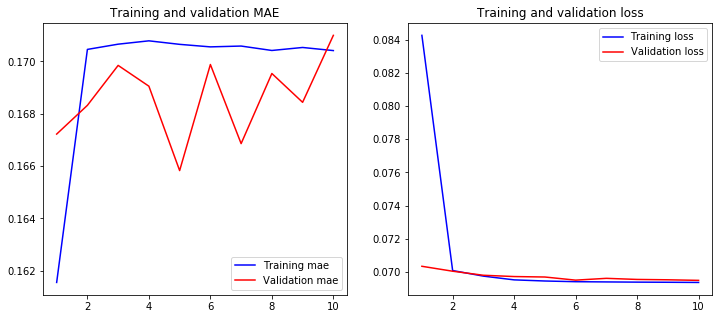

In [125]:
plot_history(history)

In [126]:
preds_ann = model.predict_proba(X_test)

In [127]:
preds_ann = pd.DataFrame(preds_ann, columns=["ann_fatal", "ann_serious", "ann_slight"])

In [128]:
preds.reset_index(inplace=True, drop=True)

In [129]:
preds = preds.merge(preds_ann, left_index=True, right_index=True)

In [130]:
preds["rps_ann"] = rps(preds["ann_fatal"], preds["ann_serious"], preds["fatal"], preds["serious"])

In [131]:
preds["rps_ann"].mean()

0.069489486515522

### Q8) Dashboard
- http://127.0.0.1:8050/

### To Do:
- get non-accident data
- get driver information
- get vehicle information